Automatically created module for IPython interactive environment


In [1]:


import numpy as np
import matplotlib.pyplot as plt

from sklearn import neighbors
from scipy.spatial import Voronoi

from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

from ipywidgets import interact
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import gridplot
from bokeh.io import push_notebook


def univariate(n_neighbors=1, n_data=5, lista=['uniform']):
    #np.random.seed(0)
    X = np.sort(5 * np.random.rand(n_data, 1), axis=0)
    T = np.linspace(0, 5, 500)[:, np.newaxis]
    y = np.sin(X).ravel()

    # Add noise to targets
    y[::5] += 1 * (0.5 - np.random.rand(int(n_data/5)))

    # #############################################################################
    # Fit regression model

    for i, weights in enumerate(lista):#, 'distance']):
        knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
        y_ = knn.fit(X, y).predict(T)

        plt.subplot(2, 1, i + 1)
        plt.scatter(X, y, c='k', label='data')
        plt.plot(T, y_, c='g', label='prediction')
        plt.axis('tight')
        plt.legend()
        plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors,
                                                                    weights))

        plt.show()

##################################################################################################

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)
def voronoi_p(number):
    # make up data points
    #np.random.seed(1234)
    points = np.random.rand(number, 2)

    # compute Voronoi tesselation
    vor = Voronoi(points)

    # plot
    regions, vertices = voronoi_finite_polygons_2d(vor)
    #print( "--")
    #print( regions)
    #print( "--")
    #print( vertices)

    # colorize
    for region in regions:
        polygon = vertices[region]
        plt.fill(*zip(*polygon), alpha=0.4)

    plt.plot(points[:,0], points[:,1], 'ko')
    plt.xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
    plt.ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)

    plt.show()    
   

###################################################################33
##################################################################3
def bivariate(n_neighbors=9):

    # import some data to play with
    iris = datasets.load_iris()

    # we only take the first two features. We could avoid this ugly
    # slicing by using a two-dim dataset
    X = iris.data[:, :2]
    y = iris.target

    h = .02  # step size in the mesh

    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    for weights in ['uniform', 'distance']:
        # we create an instance of Neighbours Classifier and fit the data.
        clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
        clf.fit(X, y)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.figure()
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

        # Plot also the training points
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                    edgecolor='k', s=20)
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.title("3-Class classification (k = %i, weights = '%s')"
                  % (n_neighbors, weights))

    plt.show()
    
##########################################3
########################################
#################################3

def local_regression(x0, X, Y, tau):
    # add bias term
    x0 = np.r_[1, x0]
    X = np.c_[np.ones(len(X)), X]
    
    # fit model: normal equations with kernel
    xw = X.T * radial_kernel(x0, X, tau)
    beta = np.linalg.pinv(xw @ X) @ xw @ Y
    
    # predict value
    return x0 @ beta

def radial_kernel(x0, X, tau):
    return np.exp(np.sum((X - x0) ** 2, axis=1) / (-2 * tau * tau))
def plot_lwr(tau):
    # prediction
    domain = np.linspace(-3, 3, num=300)
    prediction = [local_regression(x0, X, Y, tau) for x0 in domain]

    plot = figure(plot_width=400, plot_height=400)
    plot.title.text = 'tau=%g' % tau
    plot.scatter(X, Y, alpha=.3)
    plot.line(domain, prediction, line_width=2, color='red')
    
    return plot

def interactive_update(tau):
    model.data_source.data['y'] = [local_regression(x0, X, Y, tau) for x0 in domain]
    push_notebook()
output_notebook()


Loading BokehJS ...

Notes based on:

http://www.cs.northwestern.edu/~pardo/courses/eecs349/lectures/eecs349_memory_based_learning.pdf

https://medium.com/100-days-of-algorithms/day-97-locally-weighted-regression-c9cfaff087fb

### Instance(memory)-based learning.

Classification:
Learning a function to map from a n-tuple to a discrete value from a finite set.

Regression:
Learning a function to map from a n-tuple to a continuous value.

### Nearest Neighbors.
Memory based learning.
Basic Idea:

1.- Get some example set of cases with known outputs.
(Diagnosis of diseases.)

2.-When you see a new case, assign its output to be the same as the most similar known case.
(Your simptomes resemble Mr. T, 
 Mr. T has the flu,
 Ergo you have the flu).

### CHOOSING SPEED
Suppose you want to learn to drive in Tallahassee, then you will notice that no one follows the speed limit!

How fast should you drive? 

Strategy 1:
-use the same speed of the car in front of you.


What if the driver behind you is closer and it is going faster?





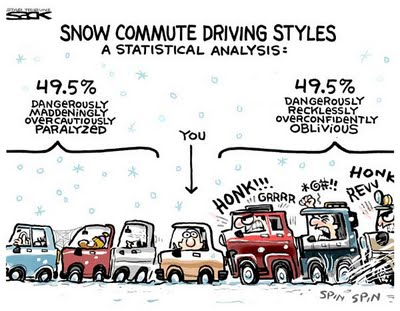

In [44]:
from IPython.display import Image
Image("driving.jpg")

Strategy 2:
-use the same speed of the nearest car (infront or behind you).

Given a set of samples $X$ with features, there is a target function $f:X\mapsto Y$ onto some finite set $Y.$

The data is a set of touples: $(x_i,f(x_i))$ and our goal is to find $h$ such that $h(x_i)\simeq f(x_i).$


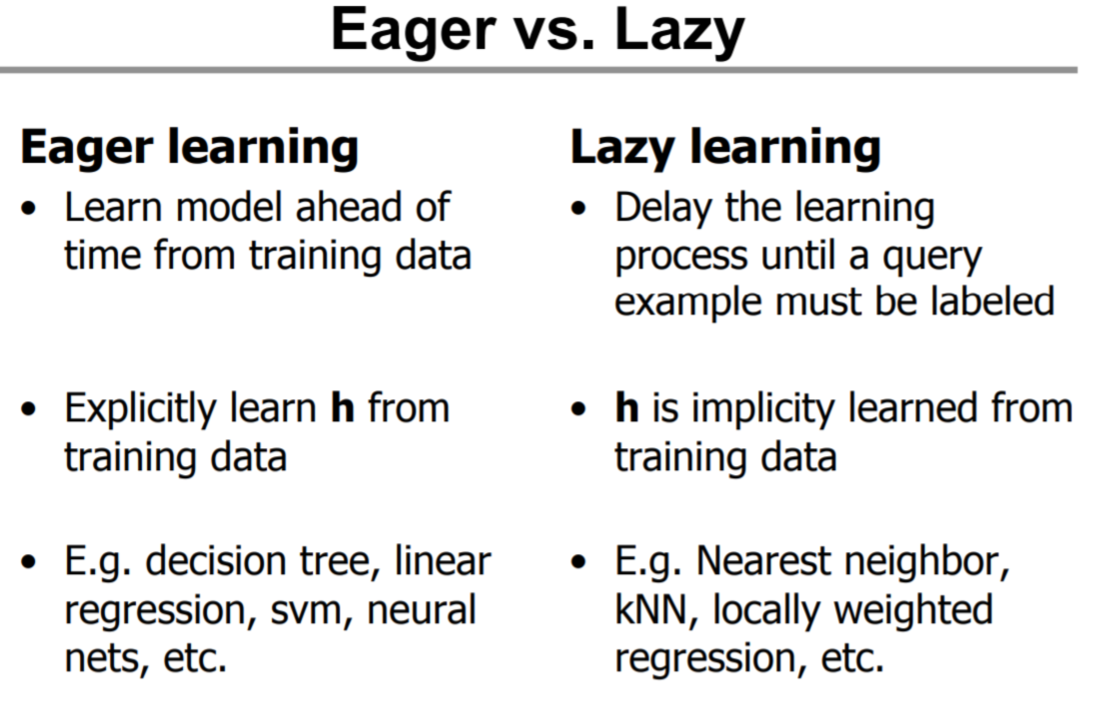

In [7]:
Image("learning.png")

### UNIVARIATE EXAMPLE

In [76]:
#Thanks to the author: Alexandre Gramfort <alexandre.gramfort@inria.fr>
#         Fabian Pedregosa <fabian.pedregosa@inria.fr>

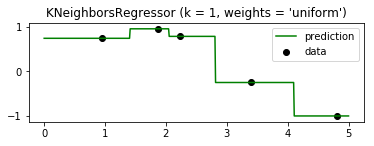

In [97]:
univariate(1,5) #Nbh,data in multiples of 5

Two dimensional case, Voronoi diagrams.

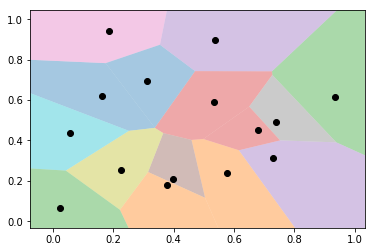

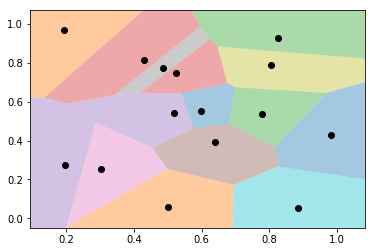

In [90]:
voronoi_p(15)

### What makes a memory based learner?

1.- a distance measure (ex: Euclidean)

2.- number of neighbors to consider (one)

3.- a weighting function (optional)

4.- how to fit the neighbors (same output as nearest)

### k-nearest neighbors.

1.- a distance measure (ex: Euclidean)

2.- number of neighbors to consider (k)

3.- a weighting function (optional)

4.- how to fit the neighbors 
(regression: average output among k nearest neighbors

classification: most popular output among k nearest neighbors)

### Choosing K
Too small k fits the output to the noise in the data set (overfit).

Too large k can make decision boudaries in classification indistinct (underfit).

Choose k empirically using cross-validation.

### Examples with k=9

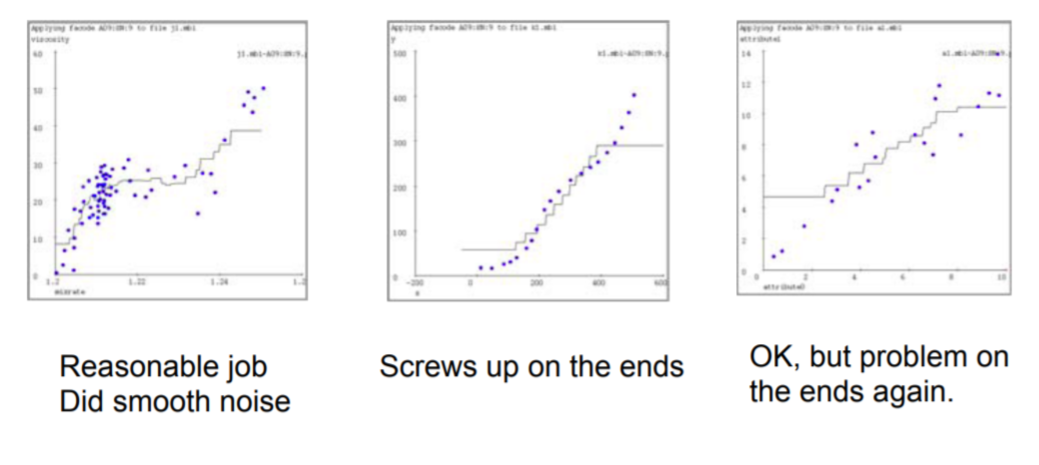

In [45]:
Image('knn9.png')

### Kernel regression

1.- a distance measure (ex:scaled Euclidean)

2.- number of neighbors to consider (all of them)

3.- $w_i=e^{\frac{-d(x_i,x_q)^2}{K^2}}, K$ is the kernel width.
Notice the difference of values on nearby points vs far points.

4.- how to fit the neighbors 
$h(x_q)=\frac{\sum w_i\cdot f(x_i)}{\sum w_i}$

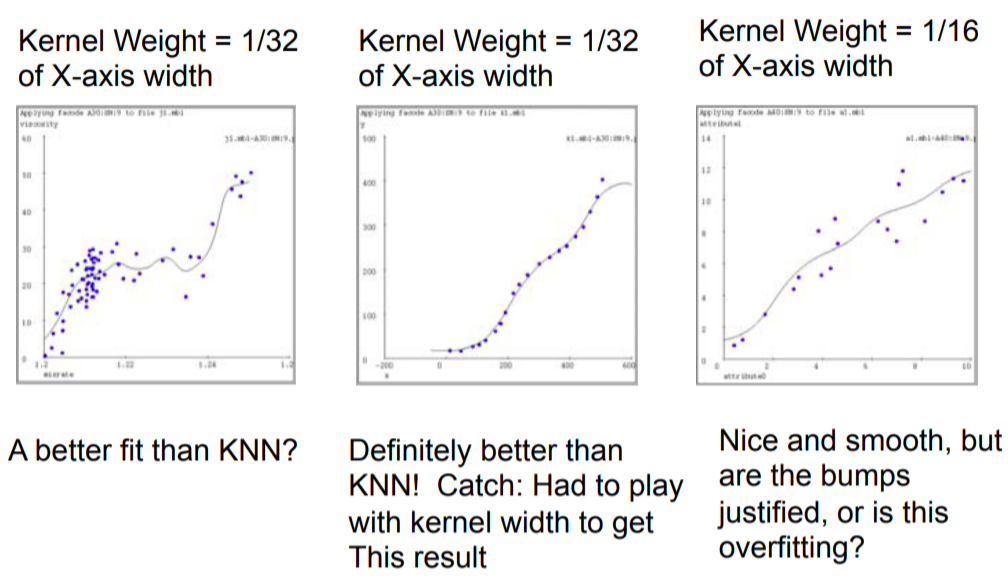

In [46]:
Image('knn32.png')

Automatically created module for IPython interactive environment


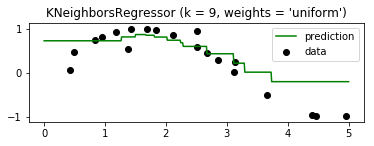

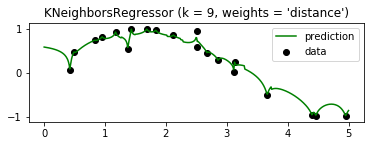

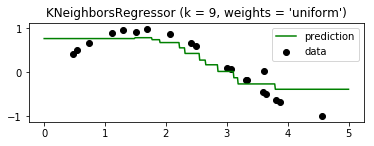

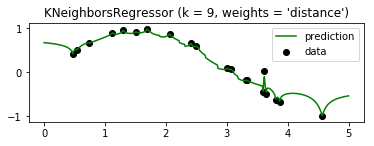

In [98]:

univariate(9,20,['uniform', 'distance'])

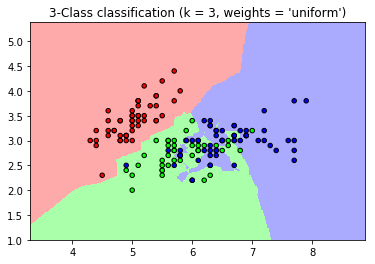

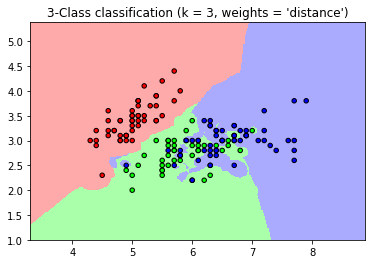

In [103]:

bivariate(3)#Iris database

## KNN, Kernel Regression
### Pros
Robust to noise

Very effective when training data is sufficient

Customized to each querry

Easily adapts when new training data is added

### Cons
How to weight different dimensions?

Irrelevant dimensions

Computationally expensive to label a new query

High space requirements ( must retain each training example)


### Locally Weighted Linear Regression
Linear regression: global, linear

err=$\sum \frac{1}{2}(f(x)-h(x))^2,\, h(x)=ax+b$

KNN: local, constant.

LW linear regression: local, linear

$err(x_q)=\sum \frac{1}{2}(f(x)-h(x))^2e^{\frac{-d(x,x_q)}{K^2}}$

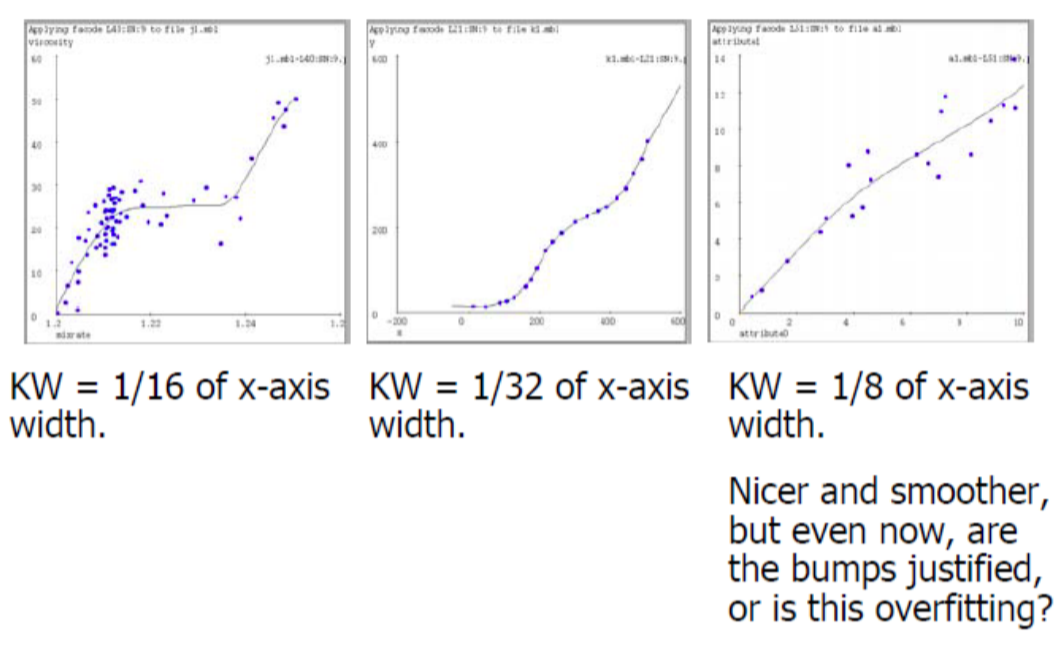

In [66]:
Image('lclr.png')

### Locally Weighted Polynomial Regression
We can use polynomials instead of linear functions.

Loading BokehJS ...

In [117]:

n = 1000

# generate dataset
X = np.linspace(-3, 3, num=n)
Y = np.log(np.abs(X ** 2 - 1) + .5)

# jitter X
X += np.random.normal(scale=.1, size=n)


domain = np.linspace(-3, 3, num=100)
prediction = [local_regression(x0, X, Y, 1.) for x0 in domain]

plot = figure()
plot.scatter(X, Y, alpha=.3)
model = plot.line(domain, prediction, line_width=2, color='red')
show(plot, notebook_handle=True)

In [118]:
interact(interactive_update, tau=(0.01, 3., 0.01))

interactive(children=(FloatSlider(value=1.5, description='tau', max=3.0, min=0.01, step=0.01), Output()), _dom…

<function __main__.interactive_update(tau)>

## Memory-based Learning
### Pros
Easily adapts to new training samples (no need to retrain)

Can handle complex decision boundaries and functions by considering the query instance when deciding how to generalize

### Cons
Requires retaining all training examples in memory

Slow to evaluate a new query

Evaluation time grows with the dataset size


## Summary

Memory-based learning are 'lazy', delay learning until receiving a query

Local, training data that is localized around the query contribute more to the prediction value

Non parametric

Robust to noise

Curse of dimensionality:

    Irrelevant dimensions

    How to scale dimensions
    
Nearest Neighbor

    Output the nearest neighbor's label
    
KNN 

    Output the average of the k NN's labels
    
Kernel regression

    Output weighted average of all training data (or k NN's) labels
    
Locally weighted (linear) regression

    Fit a linear function locally
    
    
    